In [130]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings
from datetime import datetime
from scipy.optimize import minimize
import scipy.special as ss
warnings.filterwarnings("ignore")

In [131]:
df=pd.read_csv("Merged_data.csv")

In [132]:
df.tail()

,Date,Open,Close,High,Low,Volume,ADS_Index,Mkt-RF,SMB,HML,RF,Returns,SP500,Open_Close,High_Low,HLOC,EWM_OpenClose
664,2018-08-24,1912.00,1905.00,1916.01,1902.54,16706,0.335919,0.62,-0.05,-0.51,0.007,-0.001050,2874.69,1908.500,1909.275,1908.8875,1898.543330
665,2018-08-27,1914.00,1932.30,1933.00,1909.28,17780,0.299340,0.74,-0.69,-0.12,0.007,0.001308,2896.74,1923.150,1921.140,1922.1450,1906.745553
666,2018-08-28,1933.00,1935.01,1941.78,1927.68,18557,0.285254,-0.01,-0.12,-0.29,0.007,0.011631,2897.52,1934.005,1934.730,1934.3675,1915.832036
667,2018-08-29,1945.00,1999.75,2001.85,1937.50,39327,0.270082,0.56,-0.04,-0.59,0.007,0.002663,2914.04,1972.375,1969.675,1971.0250,1934.679690
668,2018-08-30,2000.12,2002.15,2025.58,1986.90,41585,0.253823,-0.41,0.30,-0.43,0.007,0.033217,2901.13,2001.135,2006.240,2003.6875,1956.831460


In [133]:
Y = df[['Open ']].as_matrix()

**EMA**

An exponential moving average (EMA), also known as an exponentially weighted moving average (EWMA). 

**Formula**

Exponential moving average = [Close - previous EMA] * (2 / n+1) + previous EMA

In [173]:
def EMA_train(Y):
    T= Y.shape[0]  
    X_EMA = df[['EWM_OpenClose']].as_matrix()
    X_EMA = np.column_stack([np.ones((T,1)),X_EMA])
    N1 = X_EMA.shape        
    invXTX = np.linalg.inv(X_EMA.transpose()@X_EMA)
    beta_hat = invXTX@X_EMA.transpose()@Y
    Y_HAT_EMA = X_EMA@beta_hat
    residuals = Y-Y_HAT_EMA
    variance = (1/T)*residuals.transpose()@residuals  
    std = np.sqrt(variance)
    var_cov_beta = variance*invXTX   
    std_cov_beta = np.sqrt(T*np.diag(var_cov_beta))
    t_stat = (beta_hat.transpose()-0)/std_cov_beta
    p_val_t = 1-stats.norm.cdf(t_stat)
    MSE = (sum((Y-Y_HAT_EMA)**2))/(len(X_EMA)-len(X_EMA[0]))
    var_b = MSE*(np.linalg.inv(np.dot(X_EMA.T,X_EMA)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = beta_hat/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_EMA)-1))) for i in ts_b]
    f_stat = (beta_hat.transpose()@np.linalg.inv(var_cov_beta)@beta_hat/N1[1])/(residuals.transpose()@residuals/(T-N1[1]))
    p_val_f = 1-stats.f.cdf(f_stat, N1[1]-1, len(X_EMA)-N1[1])
    R2 = 1-T*variance/(T*np.var(Y))
    R2_adj = 1-(1-R2)*(T-1)/(T-N1[1])
    return beta_hat,Y_HAT_EMA,Y,t_stat,p_val_t,f_stat,p_val_f,R2,R2_adj

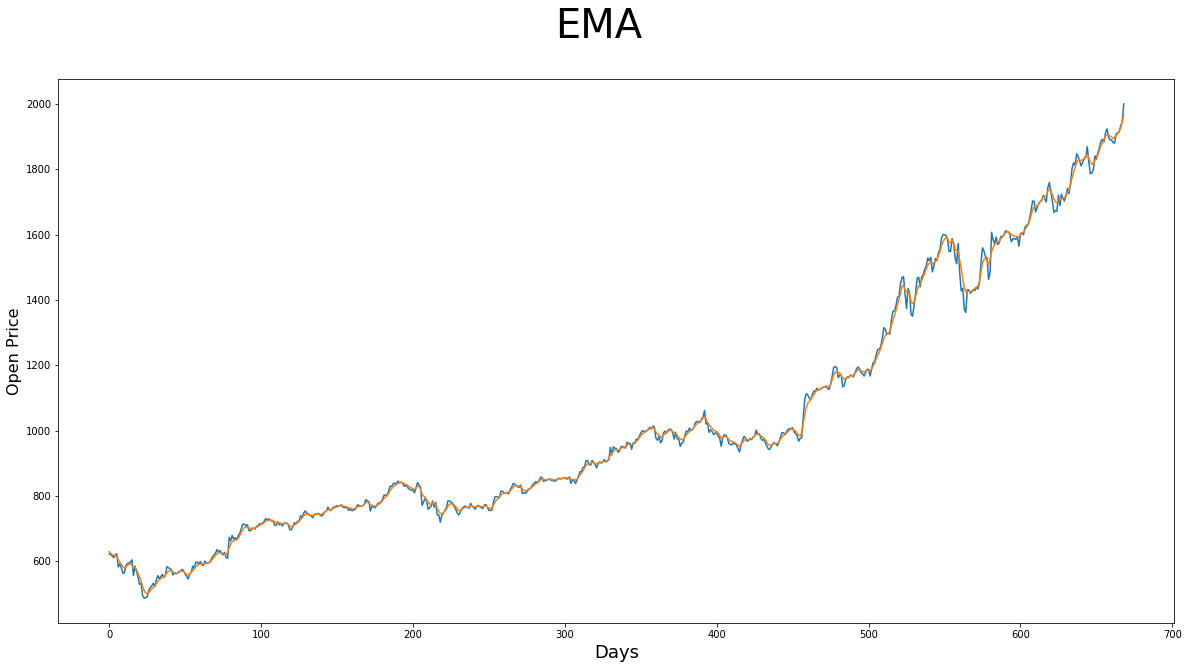

In [174]:
beta_hat,Y_HAT_EMA,Y,t_stat,p_val_t,f_stat,p_val_f,R2,R2_adj= EMA_train(Y)
plt.figure( figsize=(20,10)).suptitle('EMA', fontsize=40)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Open Price', fontsize=16)
plt.plot(Y)
plt.plot(Y_HAT_EMA)

In [175]:
RMSE_EMA=np.sqrt(np.mean((Y - Y_HAT_EMA)**2))

In [176]:
RMSE_EMA

12.735575701307704

**Moving Average of High low and close with ads index**

The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.


The Simple Moving Average formula is a very basic arithmetic mean over the number of periods.

Simple moving average = (P1 + P2 + P3 + P4 + ... + Pn) / n.

In [180]:
def MA_HL(Y):
    T=Y.shape[0]
    df["moving_average_HLC"] = (df["High"] + df["Low"] + df ["Close "]) /3
    X =df[['moving_average_HLC','ADS_Index']].as_matrix()
    N=X.shape
    invXTX=np.linalg.inv(X.transpose()@X)
    beta_hat = invXTX@X.transpose()@Y
    y_hat = X@beta_hat
    residuals = Y-y_hat
    variance = (1/T)*residuals.transpose()@residuals  
    std = np.sqrt(variance)
    var_cov_beta = variance*invXTX   
    std_cov_beta = np.sqrt(T*np.diag(var_cov_beta))
    t_stat = (beta_hat.transpose()-0)/std_cov_beta
    p_val_t = 1-stats.norm.cdf(t_stat)
    MSE = (sum((Y-y_hat)**2))/(len(X)-len(X[0]))
    var_b = MSE*(np.linalg.inv(np.dot(X.T,X)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = beta_hat/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in ts_b]
    f_stat = (beta_hat.transpose()@np.linalg.inv(var_cov_beta)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
    p_val_f = 1-stats.f.cdf(f_stat, N[1]-1, len(X)-N[1])
    R2 = 1-T*variance/(T*np.var(Y))
    R2_adj = 1-(1-R2)*(T-1)/(T-N[1])
    return beta_hat, y_hat,Y,t_stat,p_val_t,f_stat,p_val_f,R2,R2_adj

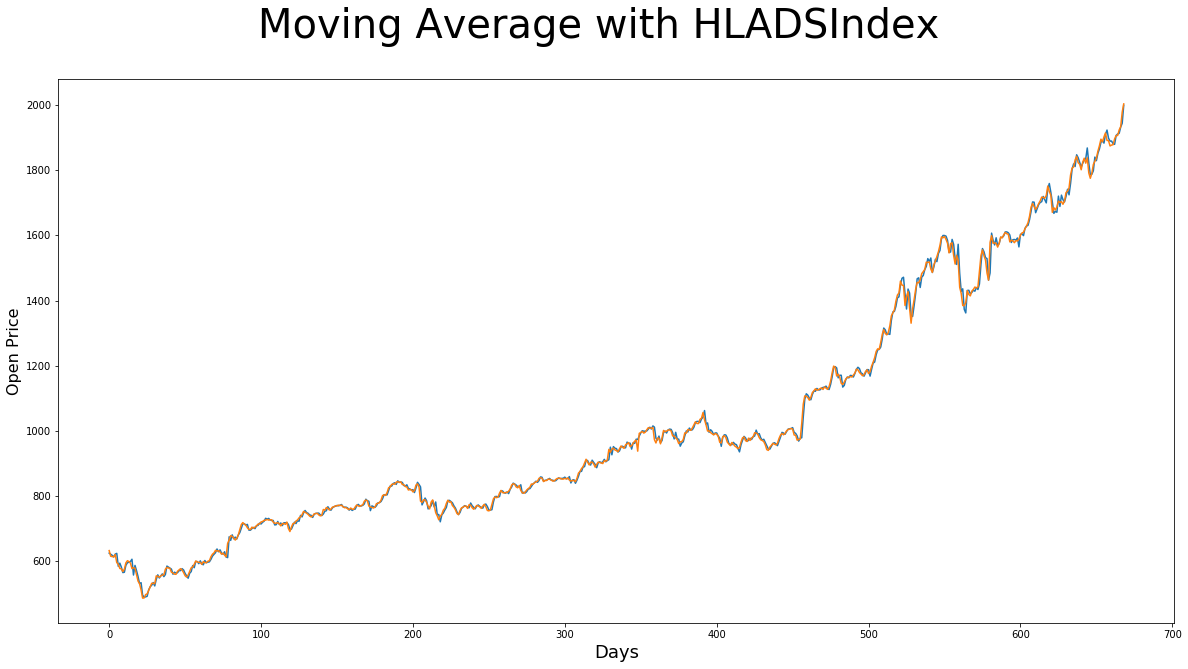

In [181]:
beta_hat, y_hat,Y,t_stat,p_val_t,f_stat,p_val_f,R2,R2_adj=MA_HL(Y)
plt.figure( figsize=(20,10)).suptitle('Moving Average with HLADSIndex', fontsize=40)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Open Price', fontsize=16)
plt.plot(Y)
plt.plot(y_hat)

In [182]:
RMSE_MA=np.sqrt(np.mean((Y - y_hat)**2))

In [183]:
RMSE_MA

11.654367973289219

In [190]:
R2_adj

array([[0.99901691]])

**AR With All Factors**

An autoregressive (AR) model predicts future behavior based on past behavior. It’s used for forecasting when there is some correlation between values in a time series and the values that precede and succeed them. You only use past data to model the behavior, hence the name autoregressive (the Greek prefix auto– means “self.” ). The process is basically a linear regression of the data in the current series against one or more past values in the same series.


In [191]:
def ARF(Y):
    X = df[['High','Low','Close ','Mkt-RF','SMB','HML','ADS_Index']].as_matrix()
    N = X.shape
    T = Y.shape[0]
    invXX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXX@X.transpose()@Y
    Y_HAT = X@beta_hat
    residuals = Y -Y_HAT
    variance = (1/T)*residuals.transpose()@residuals
    std = np.sqrt(variance)
    varcov_beta_hat = (variance)*invXX
    std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))
    t_stat=(beta_hat.transpose()-0)/std_beta_hat
    p_val_t= 1-stats.norm.cdf(t_stat)
    MSE = (sum((Y-Y_HAT)**2))/(len(X)-len(X[0]))
    var_b = MSE*(np.linalg.inv(np.dot(X.T,X)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = beta_hat/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in ts_b]
    R_square = 1 - (residuals.transpose()@residuals)/(T*np.var(Y))
    adj_R_square = 1-(1-R_square)*(T-1)/(T-N[1])
    F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
    p_val_F = 1 - stats.f.cdf(F_stat,N[1]-1,T-N[1])
    
    print(p_val_t)
    return beta_hat, Y_HAT,Y,t_stat,p_val_t,F_stat,p_val_F,R_square,adj_R_square

[[0.14962332 0.16401167 0.62784234 0.59759957 0.45486614 0.39759955
  0.51278131]]


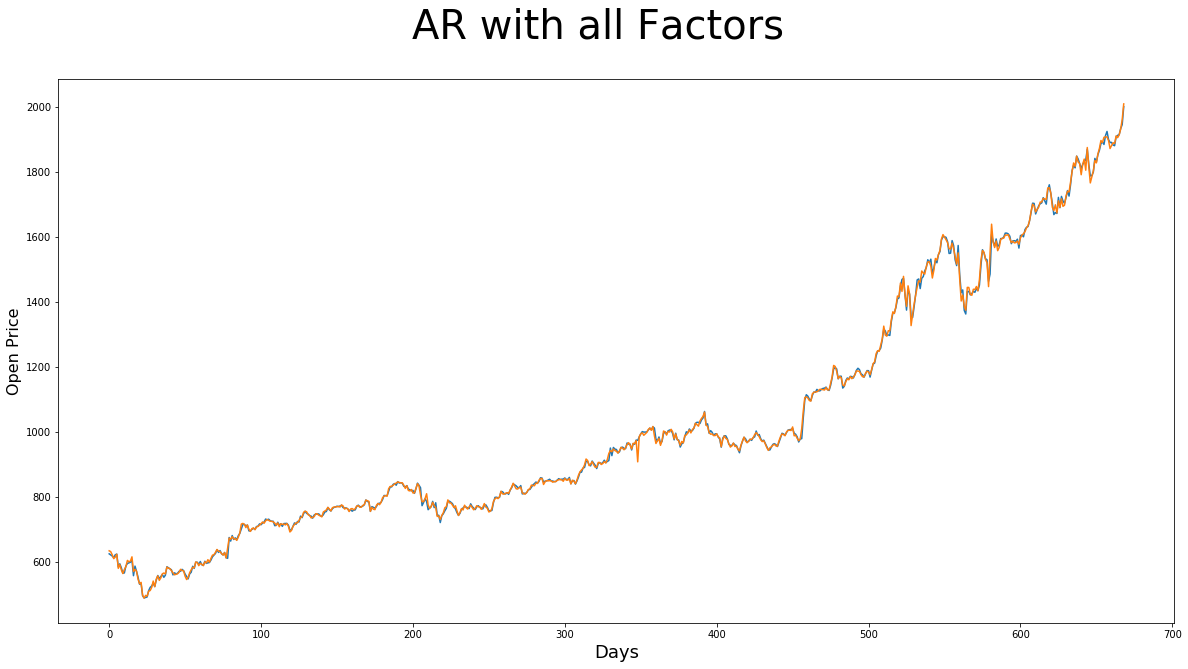

In [192]:
beta_hat, Y_HAT,Y,t_stat,p_val_t,F_stat,p_val_F,R_square,adj_R_square=ARF(Y)
plt.figure( figsize=(20,10)).suptitle('AR with all Factors', fontsize=40)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Open Price', fontsize=16)
plt.plot(Y)
plt.plot(Y_HAT)

In [193]:
RMSE_ARF=np.sqrt(np.mean((Y - Y_HAT)**2))

In [194]:
RMSE_ARF

7.874706419242701

In [201]:
adj_R_square

array([[0.99954778]])

**FAMA FRENCH 5 FACTOR MODEL**

In [156]:
def FAMA(Y):
    X = df[['Mkt-RF','SMB','HML','SP500','Close ']].as_matrix()
    N = X.shape
    T = Y.shape[0]
    invXX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXX@X.transpose()@Y
    Y_HAT = X@beta_hat
    residuals = Y -Y_HAT
    variance = (1/T)*residuals.transpose()@residuals
    std = np.sqrt(variance)
    varcov_beta_hat = (variance)*invXX
    std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))
    t_stat=(beta_hat.transpose()-0)/std_beta_hat
    p_val_t= 1-stats.norm.cdf(t_stat)
    MSE = (sum((Y-Y_HAT)**2))/(len(X)-len(X[0]))
    var_b = MSE*(np.linalg.inv(np.dot(X.T,X)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = beta_hat/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in ts_b]
    R_square = 1 - (residuals.transpose()@residuals)/(T*np.var(Y))
    adj_R_square = 1-(1-R_square)*(T-1)/(T-N[1])
    F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
    p_val_F = 1 - stats.f.cdf(F_stat,N[1]-1,T-N[1])
    print(p_values)
    return beta_hat, Y_HAT,Y,t_stat,p_val_t,F_stat,p_val_F,R_square,adj_R_square

[array([0., 0., 0., 0., 0.]), array([0.00132047, 0.03238349, 0.02393565, 0.        , 0.        ]), array([0., 0., 0., 0., 0.]), array([0.99874982, 0.99916886, 0.99912265, 0.2134127 , 0.57246079]), array([0.16667376, 0.3576848 , 0.33160429, 0.        , 0.        ])]


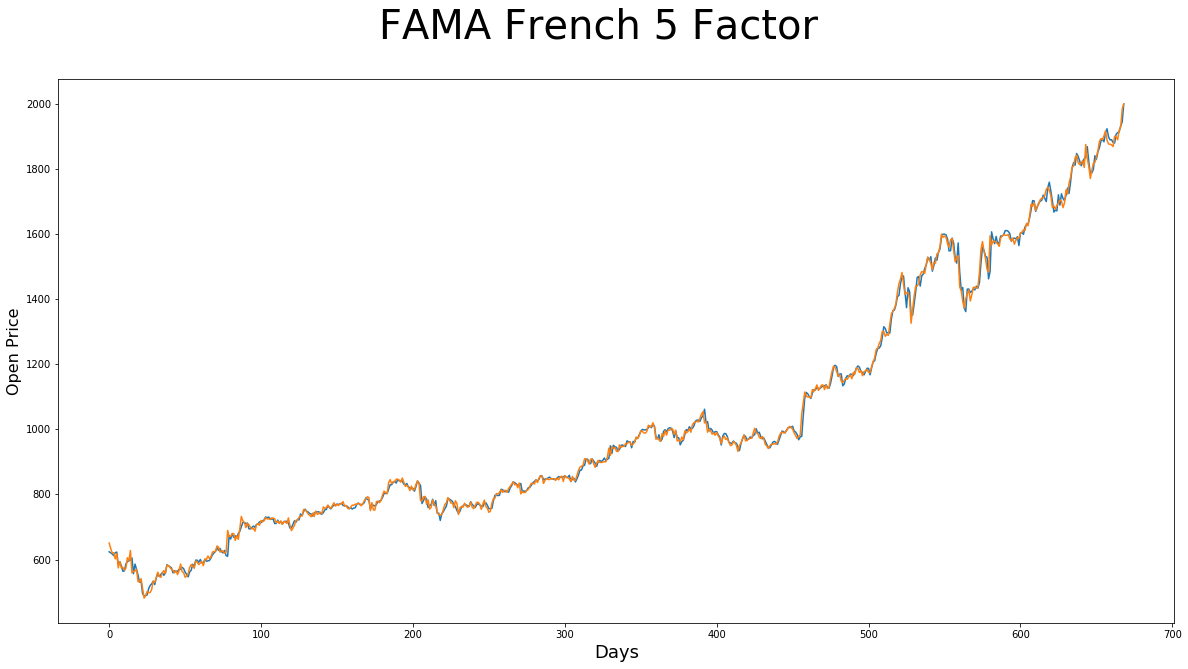

In [157]:
beta_hat,Y_HAT,Y,t_stat,p_val_t,F_stat,p_val_F,R_square,adj_R_square=FAMA(Y)
plt.figure( figsize=(20,10)).suptitle('FAMA French 5 Factor', fontsize=40)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Open Price', fontsize=16)
plt.plot(Y)
plt.plot(Y_HAT)

In [162]:
RMSE_FAMA=np.sqrt(np.mean((Y - Y_HAT)**2))

In [163]:
RMSE_FAMA

13.683692178428078

**MACD**

In [202]:
def MACD(Y):
    exp1 = df.Open_Close.ewm(span=12, adjust=False).mean()
    exp2 = df.Open_Close.ewm(span=26, adjust=False).mean()
    X=exp2-exp1
    T = Y.shape[0]
    X = np.column_stack([np.ones((T,1)),X])
    N = X.shape
    invXX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXX@X.transpose()@Y
    Y_HAT = X@beta_hat
    residuals = Y -Y_HAT
    variance = (1/T)*residuals.transpose()@residuals
    std = np.sqrt(variance)
    varcov_beta_hat = (variance)*invXX
    std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))
    t_stat=(beta_hat.transpose()-0)/std_beta_hat
    p_val_t= 1-stats.norm.cdf(t_stat)
    print(p_val_t)
    MSE = (sum((Y-Y_HAT)**2))/(len(X)-len(X[0]))
    var_b = MSE*(np.linalg.inv(np.dot(X.T,X)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = beta_hat/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in ts_b]
    R_square = 1 - (residuals.transpose()@residuals)/(T*np.var(Y))
    adj_R_square = 1-(1-R_square)*(T-1)/(T-N[1])
    F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
    p_val_F = 1 - stats.f.cdf(F_stat,N[1]-1,T-N[1])
    return beta_hat, Y_HAT,Y,t_stat,p_val_t,F_stat,p_val_F,R_square,adj_R_square

[[0.00944183 0.79286163]]


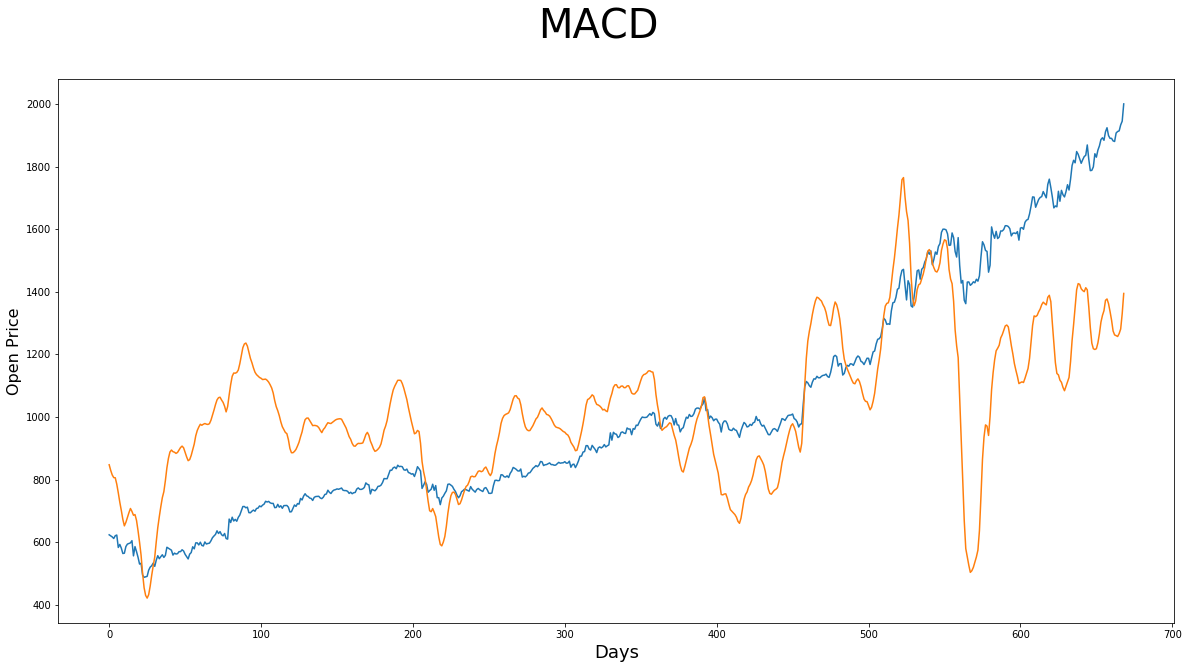

In [203]:
beta_hat, Y_HAT,Y,t_stat,p_val_t,F_stat,p_val_F,R_square,adj_R_square=MACD(Y)
plt.figure( figsize=(20,10)).suptitle('MACD', fontsize=40)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Open Price', fontsize=16)
plt.plot(Y)
plt.plot(Y_HAT)

In [204]:
RMSE_MACD=np.sqrt(np.mean((Y - Y_HAT)**2))

In [205]:
RMSE_MACD

288.1480398063374

In [214]:
adj_R_square

array([[0.39903807]])